# Spin Squeezing

Notebook author: Nathan Shammah (nathan.shammah at gmail.com)

Here we study the effect of collective and local processes on a spin squeezing Hamiltonian. 

We consider a system of $N$ two-level systems (TLSs) with identical frequency $\omega_{0}$, which can de-excite incoherently or collectively at the rates $\gamma_\text{E}$ and $\gamma_\text{CE}$,

\begin{eqnarray}
\dot{\rho} &=&-i\lbrack -i\Lambda\left(J_{+}^2-J_{-}^2\right),\rho \rbrack
+\frac{\gamma_\text {CE}}{2}\mathcal{L}_{J_{-}}[\rho]
+\frac{\gamma_\text{E}}{2}\sum_{n=1}^{N}\mathcal{L}_{J_{-,n}}[\rho]
\end{eqnarray}

We study the time evolution of the spin squeezing parameter [1-4]
\begin{eqnarray}
\xi^2 &=& N\langle\Delta J_y^2\rangle/\left(\langle J_z\rangle^2+\langle J_x\rangle^2\right)
\end{eqnarray}

We assess how different dynamical conditions and initial states can be explored to optimize the spin squeezing of a given Dicke state [5-7].

In [1]:
from time import clock
from scipy.io import mmwrite
import matplotlib.pyplot as plt
from qutip import *
from piqs import *
from scipy.sparse import load_npz, save_npz

In [2]:
def isdicke(N, j, m):
    """
    Check if an element in a matrix is a valid element in the Dicke space.
    Dicke row: j value index. Dicke column: m value index. 
    The function returns True if the element exists in the Dicke space and
    False otherwise.

    Parameters
    ----------
    N : int
        The number of two-level systems.    
    j: float
        "j" index of the element in Dicke space which needs to be checked.
    m: float
        "m" index of the element in Dicke space which needs to be checked.
    """
    dicke_row = j
    dicke_col = m
    
    rows = N + 1
    cols = 0

    if (N % 2) == 0:
        cols = int(N/2 + 1)
    else:
        cols = int(N/2 + 1/2)

    if (dicke_row > rows) or (dicke_row < 0):
        return (False)

    if (dicke_col > cols) or (dicke_col < 0):
        return (False)

    if (dicke_row < int(rows/2)) and (dicke_col > dicke_row):
        return False

    if (dicke_row >= int(rows/2)) and (rows - dicke_row <= dicke_col):
        return False

    else:
        return True

def dicke_space(N):
    """
    Generate a matrix to visualize the Dicke space.
    j is on the horizontal axis, increasing right to left.
    m is on the vertical axis, increasing bottom to top.
    It puts 1 in all allowed (j,m) values.
    It puts 0 in all not-allowed (j,m) values.
    Parameters
    ----------
    N : int
        The number of two-level systems.
    Returns
    ----------
    dicke_space : ndarray
        The matrix of all allowed (j,m) pairs.

    """        
    rows = N + 1
    cols = 0

    if (rows % 2) == 0:
        cols = int((rows/2))

    else:
        cols = int((rows + 1)/2)

    dicke_space = np.zeros((rows, cols), dtype = int)

    for (i, j) in np.ndindex(rows, cols):
        dicke_space[i, j] = isdicke(N, i, j)

    return (dicke_space)

In [3]:
## general parameters
N = 50
ntls = N
nds = num_dicke_states(N)
[jx, jy, jz] = jspin(N)
jp = jspin(N, "+")
jm = jspin(N, "-")
jpjm = jp*jm

Lambda = 1
factor_l = 5

#spin hamiltonian
h = -1j*Lambda * (jp**2-jm**2)
gCE = Lambda/factor_l
gE = Lambda/factor_l

# system with collective emission only
system = Dicke(N=N)
# system2 with local emission only
system2 = Dicke(N=N)
system.collective_emission = gCE
system2.emission = gE
system.hamiltonian = h
system2.hamiltonian = h
liouv = system.liouvillian() 
liouv2 = system2.liouvillian()

print(system)
print(system2)

N = 50
Hilbert space dim = (676, 676)
Number of Dicke states = 676
Liouvillian space dim = (456976, 456976)
collective_emission = 0.2
N = 50
Hilbert space dim = (676, 676)
Number of Dicke states = 676
Liouvillian space dim = (456976, 456976)
emission = 0.2


# Time evolution of Spin Squuezing Parameter $\xi^2= \frac{N \langle\Delta J_y^2\rangle}{\langle J_z\rangle^2}$

In [4]:
#set initial state for spins (Dicke basis)
nt = 1001
td0 = 1/(N*Lambda)
tmax =  10 * td0
t = np.linspace(0, tmax, nt)
excited = dicke(N, N/2, N/2)
load_file = True
if load_file == False:
    # cycle over all states in Dicke space
    xi2_1_list = []
    xi2_2_list = []
    xi2_1_min_list = []
    xi2_2_min_list = []

    for j in j_vals(N):
        #for m in m_vals(j):
        m = j
        rho0 = dicke(N, j, m)
        #solve using qutip (Dicke basis)
        # Dissipative dynamics: Only collective emission 
        result = mesolve(liouv, rho0, t, [], 
                         e_ops = [jz, jy, jy**2,jz**2, jx],
                         options = Options(store_states=True))
        rhot = result.states
        jz_t = result.expect[0]
        jy_t = result.expect[1]
        jy2_t = result.expect[2]
        jz2_t = result.expect[3]
        jx_t = result.expect[4]
        Delta_jy = jy2_t - jy_t**2
        xi2_1 = N * Delta_jy / (jz_t**2+jx_t**2)
        # Dissipative dynamics: Only local emission 
        result2 = mesolve(liouv2, rho0, t, [], 
                          e_ops = [jz, jy, jy**2,jz**2, jx],
                          options = Options(store_states=True))
        rhot2 = result2.states
        jz_t2 = result2.expect[0]
        jy_t2 = result2.expect[1]
        jy2_t2 = result2.expect[2]
        jz2_t2 = result2.expect[3]
        jx_t2 = result2.expect[4]
        Delta_jy2 = jy2_t2 - jy_t2**2
        xi2_2 = N * Delta_jy2 / (jz_t2**2+jx_t2**2)

        xi2_1_min = np.min(xi2_1)
        xi2_2_min = np.min(xi2_2)        
        xi2_1_list.append(xi2_1)
        xi2_2_list.append(xi2_2)
        xi2_1_min_list.append(xi2_1_min)
        xi2_2_min_list.append(xi2_2_min)        

        print("|j, m> = ",j,m)

In [5]:
# # save data 
# save_file = True
# if save_file == True:
#     file_name = str("data/spin_squeezing_N{}.npz".format(N))
#     np.savez('{}'.format(file_name), N, 
#              xi2_2_min_list, xi2_1_min_list, 
#              xi2_2_list, xi2_1_list)

In [6]:
 # load data 
#Load from file (sparse)
if load_file == True:
    loadfrom_file_name = str("data/spin_squeezing_N{}.npz".format(N))
    loaded_data = np.load('{}'.format(loadfrom_file_name))
    N,xi2_2_min_list, xi2_1_min_list,xi2_2_list, xi2_1_list = (loaded_data["arr_0"],
                                                                loaded_data["arr_1"],
                                                                loaded_data["arr_2"],
                                                                loaded_data["arr_3"],
                                                                loaded_data["arr_4"])
    print("Liouvillian data loaded from {} into {}".format(loadfrom_file_name, str("liouv_data")))

Liouvillian data loaded from data/spin_squeezing_N50.npz into liouv_data


#### Visualization

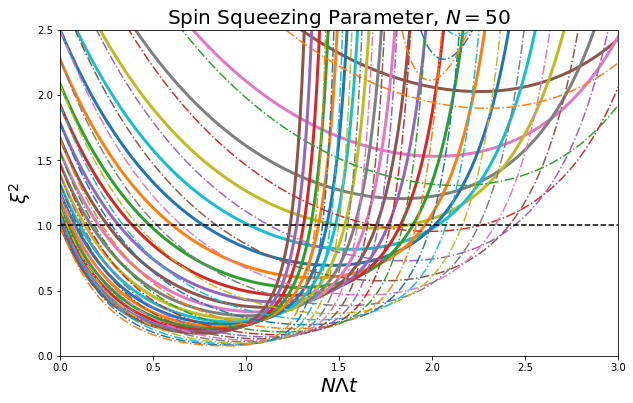

In [7]:
label_size2 = 20
lw = 3
texplot = False
# if texplot == True:
#     plt.rc('text', usetex = True)
#     plt.rc('xtick', labelsize=label_size) 
#     plt.rc('ytick', labelsize=label_size)

fig1 = plt.figure(figsize = (10,6))
for xi2_1 in xi2_1_list:
    plt.plot(t*(N*Lambda), xi2_1, '-', label = r' $\gamma_\Downarrow=0.2$', linewidth = lw)
for xi2_2 in xi2_2_list:
    plt.plot(t*(N*Lambda), xi2_2, '-.', label = r'$\gamma_\downarrow=0.2$')
plt.plot(t*(N*Lambda), 1+0*t, '--k')
plt.xlim([0,3])
plt.ylim([0,8000.5])
plt.ylim([0,2.5])
plt.xlabel(r'$ N \Lambda t$', fontsize = label_size2)
plt.ylabel(r'$\xi^2$', fontsize = label_size2)
#plt.legend(fontsize = label_size2*0.8)
savefile = False
if savefile == True:
    fname = 'figures/spin_squeezing_N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Spin Squeezing Parameter, $N={}$'.format(N), fontsize = label_size2)
plt.show()
plt.close()

In [8]:
## Here we find for how long the spin-squeezing parameter, xi2, 
## is less than 1 (non-classical or "quantum" condition), in the two dynamics

dt_quantum_xi1_list = []
dt_quantum_xi2_list = []

dt1_jm =[]
dt2_jm =[]
ds = dicke_space(N)
i = 0
for j in j_vals(N):
    #for m in m_vals(j):
    m = j
    rho0 = dicke(N, j, m)
    quantum_xi1 = xi2_1_list[i][xi2_1_list[i] < 1.0] 
    quantum_xi2 = xi2_2_list[i][xi2_2_list[i] < 1.0]

    # first ensemble
    if len(quantum_xi1)>0:
        dt_quantum_xi1 = len(quantum_xi1)
        dt1_jm.append((dt_quantum_xi1, j, m))

    else:
        dt_quantum_xi1 = 0.0

    # second ensemble
    if len(quantum_xi2)>0:
        dt_quantum_xi2 = len(quantum_xi2)
        dt2_jm.append((dt_quantum_xi2, j, m))
    else:
        dt_quantum_xi2 = 0.0

    dt_quantum_xi1_list.append(dt_quantum_xi1)
    dt_quantum_xi2_list.append(dt_quantum_xi2)

    i = i+1

/Users/nathanshammah/Downloads/Applications/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Users/nathanshammah/Downloads/Applications/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [9]:
print("collective emission")
print(dt1_jm)
print("local emission")
print(dt2_jm)

collective emission
[(36, 8.0, 8.0), (101, 9.0, 9.0), (124, 10.0, 10.0), (135, 11.0, 11.0), (141, 12.0, 12.0), (144, 13.0, 13.0), (145, 14.0, 14.0), (145, 15.0, 15.0), (144, 16.0, 16.0), (142, 17.0, 17.0), (140, 18.0, 18.0), (138, 19.0, 19.0), (135, 20.0, 20.0), (133, 21.0, 21.0), (130, 22.0, 22.0), (128, 23.0, 23.0), (126, 24.0, 24.0), (123, 25.0, 25.0)]
local emission
[(57, 7.0, 7.0), (132, 8.0, 8.0), (157, 9.0, 9.0), (168, 10.0, 10.0), (173, 11.0, 11.0), (175, 12.0, 12.0), (174, 13.0, 13.0), (172, 14.0, 14.0), (169, 15.0, 15.0), (166, 16.0, 16.0), (163, 17.0, 17.0), (160, 18.0, 18.0), (156, 19.0, 19.0), (152, 20.0, 20.0), (149, 21.0, 21.0), (146, 22.0, 22.0), (143, 23.0, 23.0), (140, 24.0, 24.0), (137, 25.0, 25.0)]


In [10]:
ratio_squeezing_local = (175/137)
ratio_squeezing_collective = 145/123

#### Visualization

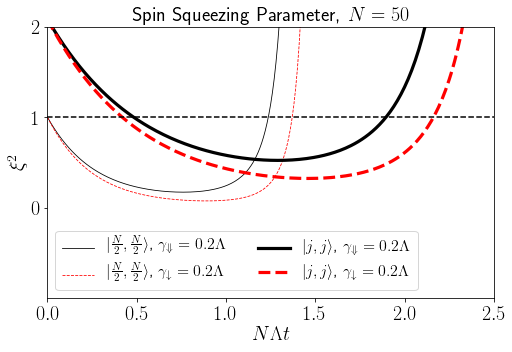

In [11]:
plt.rc('text', usetex = True)
label_size = 20
label_size2 = 20
label_size3 = 20
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

lw = 3
i0 = -14
i0s=2
fig1 = plt.figure(figsize = (8,5))
# excited state spin squeezing
plt.plot(t*(N*Lambda), xi2_1_list[-1], 'k-', 
         label = r'$|\frac{N}{2},\frac{N}{2}\rangle$, $\gamma_\Downarrow=0.2\Lambda$', 
         linewidth = 0.8)
plt.plot(t*(N*Lambda), xi2_2_list[-1], 'r--',
         label = r'$|\frac{N}{2},\frac{N}{2}\rangle$, $\gamma_\downarrow=0.2\Lambda$',
         linewidth = 0.8)
# state with max time of spin squeezing

plt.plot(t*(N*Lambda), xi2_1_list[i0], 'k-', 
         label = r'$|j,j\rangle$, $\gamma_\Downarrow=0.2\Lambda$', 
         linewidth = 0.8+0.4*i0s*lw)
plt.plot(t*(N*Lambda), xi2_2_list[i0], 'r--',
         label = r'$|j,j\rangle$, $\gamma_\downarrow=0.2\Lambda$',
         linewidth = 0.8+0.4*i0s*lw)
plt.plot(t*(N*Lambda), 1+0*t, '--k')

plt.xlim([0,2.5])
plt.yticks([0,1,2])
plt.ylim([-1,2.])

plt.xlabel(r'$ N \Lambda t$', fontsize = label_size3)
plt.ylabel(r'$\xi^2$', fontsize = label_size3)
plt.legend(fontsize = label_size2*0.8, ncol=2)
fname = 'figures/spin_squeezing_N_{}_states.pdf'.format(N)
savefigure = False
if savefigure == True:
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Spin Squeezing Parameter, $N={}$'.format(N), fontsize = label_size2)
plt.show()
plt.close()

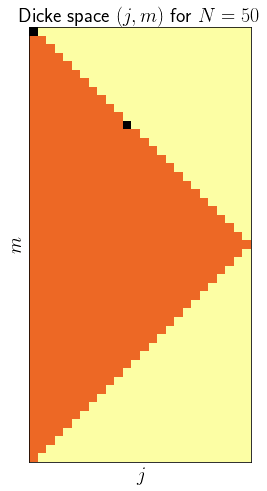

In [12]:
# plot the dt matrix in the Dicke space
plt.rc('text', usetex = True)
label_size = 20
label_size2 = 20
label_size3 = 20
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

lw = 3
i0 = -14
i0s=2
fig1 = plt.figure(figsize = (6,8))
ds = dicke_space(N)
value_excited = 3
ds[0,0]=value_excited
ds[int(N/2-14),int(N/2-14)]=value_excited * ratio_squeezing_local
plt.imshow(ds, cmap="inferno_r")
plt.xticks([])
plt.yticks([])
plt.xlabel(r"$j$", fontsize = label_size3)
plt.ylabel(r"$m$", fontsize = label_size3)
plt.title(r"Dicke space $(j,m)$ for $N={}$".format(N), fontsize = label_size3)
plt.show()
plt.close()

#### References

[1] D. J. Wineland, J. J. Bollinger, W. M. Itano, F. L. Moore, and D. J. Heinzen, Spin squeezing and reduced quantum noise in spectroscopy, *Phys. Rev. A* **46**, R6797 (1992)

[2] M. Kitagawa and M. Ueda, Squeezed spin states, *Phys. Rev. A* **47**, 5138 (1993)

[3] J. Ma, X. Wang, C.-P. Sun, and F. Nori, Quantum spin squeezing, *Physics Reports* **509**, 89 (2011)

[4] L. PezzeÌ€, A. Smerzi, M. K. Oberthaler, R. Schmied, and P. Treutlein, Quantum metrology with nonclassical states of atomic ensembles, *Reviews of Modern Physics*, in press (2018)

[5] B. A. Chase and J. Geremia, Collective processes of an ensemble of spin-1 particles, *Phys. Rev. A* **78**,0521012 (2008)

[6] B. Q. Baragiola, B. A. Chase, and J. Geremia, Collective uncertainty in partially polarized and partially deco- hered spin-1 systems, *Phys. Rev. A* **81**, 032104 (2010)

[7] N. Shammah, S. Ahmed, N. Lambert, S. De Liberato, and F. Nori, https://arxiv.org/abs/1805.05129

In [ ]:
qutip.about()